# EMG signal classification using Recurrent Neural Networks 

This document discusses the use of a recurrent neural network to solve the problem of classifying EMG signal to certain action.
Signals were recorded ysing Myo arm band from all of its 8 channels. 15 set of time series was recorded from 5 persons in three positions  (open hand, pointing hand, closed hand). 
*No any type of data extraction or filtration was applied before training* classifier was trained for about 800 iterations on two thirds of this data (10 sets) and it was able to classify the other $unseen$ sets 100% coreectly.

# Importing DL and Data Processing Libraries 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import tensorflow as tf
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Activation, GRU
from keras.models import Sequential , Model
from keras import optimizers , regularizers


# Data Processing

In this section, data is loaded from .mat files into and padded with zeros as session length was not equal, and the loaded into a numpy array of shape (#series,series_length,#features), then the classes are made and binarized (1,0,1)(0,1,0)(1,0,0)

X:  (9, 1339, 8) (6, 1339, 8)  and Y:  (9, 3) (6, 3)
Data plottings:


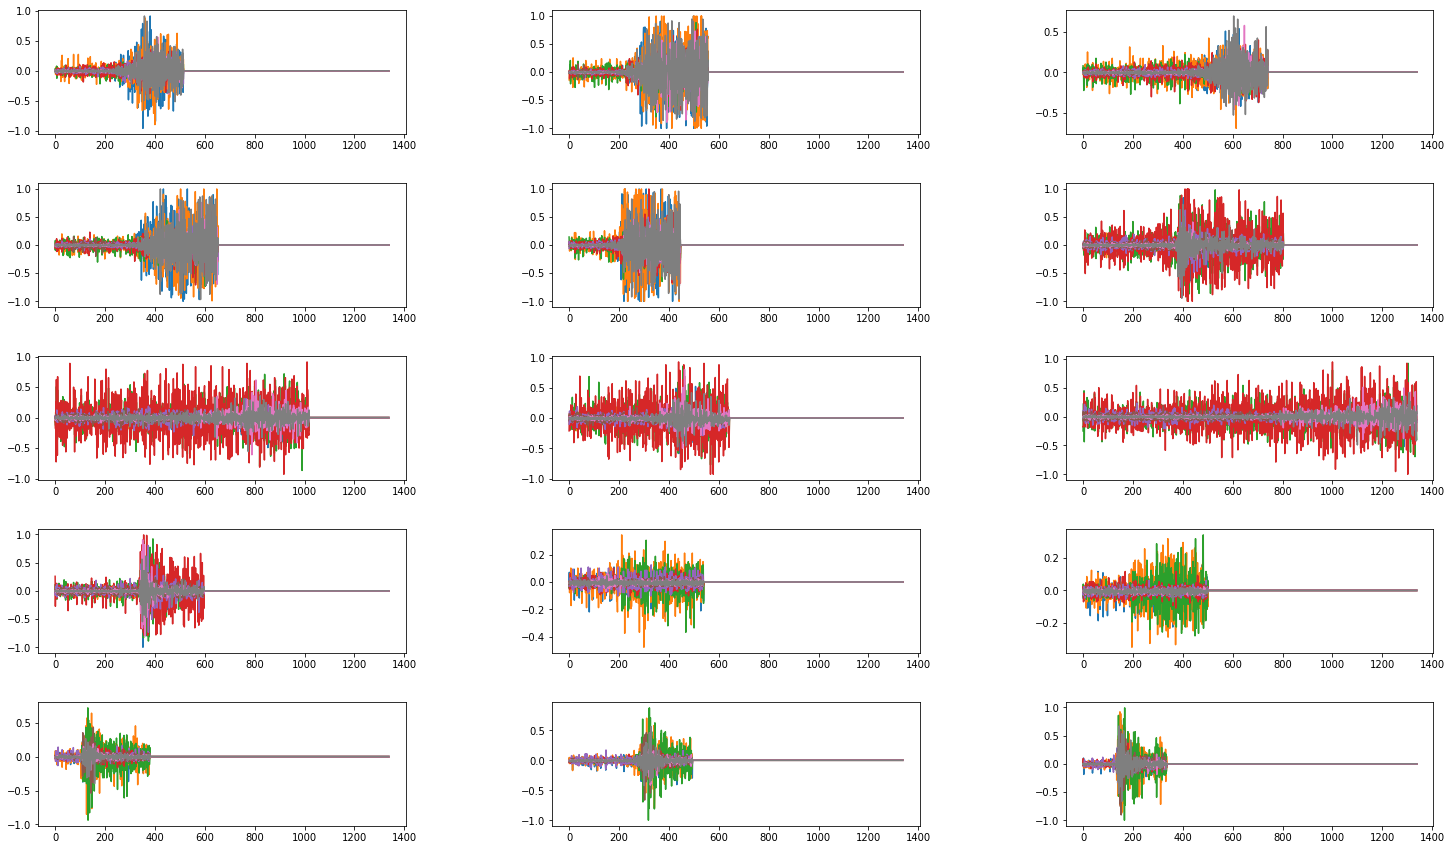

In [ ]:
#Reading Mat files
Close=[]
for i in range(1,6):
    Close.append(loadmat("./Close Hand/EMG_raw/emg_"+str(i)+".mat")['h'])
Close = np.array(Close)

Open=[]
for i in range(1,6):
    Open.append(loadmat("./Open Hand/EMG_raw/emg_"+str(i)+".mat")['h'])
Open = np.array(Open)

Point=[]
for i in range(1,6):
    Point.append(loadmat("./Point Hand/EMG_raw/emg_"+str(i)+".mat")['h'])
Point = np.array(Point)


#converting data into a numpy array of same-length raws with shape (trainign samples, series length, features)
X = np.concatenate((Close,Point,Open))
X = pad_sequences(X,dtype=np.float32,padding='post')

#Preparing Classifier output 
y1 = np.concatenate((np.zeros((5,),dtype=int),np.ones((5,),dtype=int),2*np.ones((5,),dtype=int)))
y2 = np.max(y1) + 1 #to get I matrix with diagonal equal to the max index plus one to binarize the output y1
Y = np.eye(y2)[y1]
# 0 : Closed // 1:Pointed // 2:Opened

#Data Plotting
# choose whether to plot dara or not 
plot= 1
if plot:
    fig = plt.figure(figsize=(25,15))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i in range(0, 15):
            plt.subplot(5, 3, i+1)
            plt.plot(X[i])

# Train/Test data splitting with ratio = 0.4 
X_train = np.array([X[i] for i in [0,1,2,5,6,7,10,11,12]])
Y_train = np.array([Y[i] for i in [0,1,2,5,6,7,10,11,12]])
X_test  = np.array([X[i] for i in [3,4,8,9,13,14]])
Y_test  = np.array([Y[i] for i in [3,4,8,9,13,14]])

print("X: ",X_train.shape,X_test.shape," and Y: ",Y_train.shape,Y_test.shape )
print("Data plottings:")

# Recurrent Model 

In [ ]:
# create the model
model = Sequential()
model.add(GRU(8,return_sequences=0,input_shape=(None,X.shape[-1])))
model.add(Dense(Y.shape[-1], activation='softmax'))
model.compile(loss="categorical_crossentropy", optimizer='adam' , metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 27        
Total params: 435
Trainable params: 435
Non-trainable params: 0
_________________________________________________________________
None


# Training Model 

In [ ]:
# Verbose was set to zero because printing every iteration training result will take enlarge the report
try:
    print("training...")
    model.fit(X_train, Y_train,epochs=1000,verbose=0)
except: print("Stopped")    

training...
Stopped


In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Testing Model Accuracy 

In [ ]:
print("Test Results: ",np.argmax(model.predict(X_test),axis=-1))
print("True Results: ",np.argmax(Y_test,axis=-1))
print("%s: %.2f%%" % (model.metrics_names[1], model.evaluate(X_test, Y_test, verbose=0)[1]*100))

Test Results:  [0 0 1 1 2 2]
True Results:  [0 0 1 1 2 2]
acc: 100.00%


### Model was able to classify the test dataset that was totally new to it with no error maybe because the problem is quite easy and they were all recorded in conditions with not so much variety. Maybe if it was tested with signals recorded in different conditions accuracy wil drop to about 85%  